## Plan A

1. A quick baseline(ordinal features/ no resample/ accuracy)
2. simply use ordinal features + resample
3. one hot features + resample
4. target encoding + resample
5. do not resample + best model above

In [182]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [183]:
data = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [184]:
target = 'HeartDiseaseorAttack'
ordinal_features = ['Education', 'Age', 'PhysHlth', 'MentHlth','GenHlth','Income']
categorical_features = ['Sex', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'Diabetes', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']
continuous_features = ['BMI']

### Split data into train_val and test

In [185]:
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(data, test_size = 0.2, stratify=data[target].values, random_state=0)

### A quick baseline

In [186]:
X_train_val = train_val.drop(columns=[target])
y_train_val = train_val[target]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val.values, test_size=0.2, random_state=0)

X_test = test.drop(columns=[target])
y_test = test[target]

In [ ]:
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

params = {'boosting_type': 'gbdt', 'objective': 'binary', 
              'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
              'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
              'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
              'metric': 'auc'}

lgbmclf = lgb.LGBMClassifier(**params)
lgbmclf.fit(X_train, y_train, eval_set=[(X_val, y_val)], categorical_feature = categorical_features, early_stopping_rounds=20)

In [22]:
lgbmclf.score(X_test, y_test)

0.9075804162724692

+ This is not a good accuracy, let us calculate the proportion of labels in data set

In [24]:
percent_1 = data['HeartDiseaseorAttack'].values.sum()/ len(data['HeartDiseaseorAttack'].values)
percent_0 = 1-percent_1
print('Label 0 take {:.2f} percent' .format(percent_0*100))
print('Label 1 take {:.2f} percent' .format(percent_1*100))

Label 0 take 90.58 percent
Label 1 take 9.42 percent


+ So if we predict all labels to be 0, we get almost the same result

### Ordinal features and resample

+ Resample data first and use the same algorithm to build the model

In [187]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
def under_sample(label, target):
    rand_state = RandomState(MT19937(SeedSequence(123456789)))
    target_usamp = target[target == label]
    target_osamp = target[target != label]
    resampled_idx = rand_state.choice(target_osamp.index, size=len(target_usamp))
    
    return resampled_idx

In [188]:
rsp_idx = under_sample(1, y_train_val)
data_balanced_0 = train_val.loc[rsp_idx, :]
data_label_1 = train_val[y_train_val == 1]
print(data_balanced_0.shape, data_label_1.shape)
data_all = pd.concat([data_balanced_0, data_label_1], axis=0)

(19114, 22) (19114, 22)


In [189]:
data_all.shape

(38228, 22)

In [105]:
X_train, X_val, y_train, y_val = train_test_split(data_all.drop(columns=[target]), data_all[target], random_state=0, test_size=0.2, stratify=data_all[target])

In [109]:
lgbmclf = lgb.LGBMClassifier(**params)
lgbmclf.fit(X_train, y_train, eval_set=[(X_val, y_val)], categorical_feature = categorical_features, early_stopping_rounds=50)
score = lgbmclf.score(X_test, y_test)

[LightGBM] [Warning] Unknown parameter: feature_name
[1]	valid_0's auc: 0.822593
[2]	valid_0's auc: 0.82888
[3]	valid_0's auc: 0.836089
[4]	valid_0's auc: 0.840762
[5]	valid_0's auc: 0.840335
[6]	valid_0's auc: 0.841749
[7]	valid_0's auc: 0.84237
[8]	valid_0's auc: 0.842356
[9]	valid_0's auc: 0.843462
[10]	valid_0's auc: 0.844147
[11]	valid_0's auc: 0.844515
[12]	valid_0's auc: 0.844967
[13]	valid_0's auc: 0.844874
[14]	valid_0's auc: 0.844857
[15]	valid_0's auc: 0.845232
[16]	valid_0's auc: 0.845694
[17]	valid_0's auc: 0.845801
[18]	valid_0's auc: 0.846021
[19]	valid_0's auc: 0.846544
[20]	valid_0's auc: 0.846759
[21]	valid_0's auc: 0.846526
[22]	valid_0's auc: 0.846979
[23]	valid_0's auc: 0.847537
[24]	valid_0's auc: 0.847704
[25]	valid_0's auc: 0.84796
[26]	valid_0's auc: 0.848113
[27]	valid_0's auc: 0.848355
[28]	valid_0's auc: 0.848405
[29]	valid_0's auc: 0.848494
[30]	valid_0's auc: 0.848658
[31]	valid_0's auc: 0.848821
[32]	valid_0's auc: 0.848947
[33]	valid_0's auc: 0.849085
[3

In [110]:
print(score)

0.727767265846736


### Target Encoding vs one_hot_encoding

+ A random forest
+ A logistic regression
+ A SVM
+ A lbgm

+ Here we still use resampled data 

+ transform ordinal features into one_hot_encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_enc(df_train, df_val, cols, is_train=True, encoder=None):
    ohe = OneHotEncoder(handle_unknown='ignore')
    if is_train == True:
        ohe.fit(df_train[cols])
        mat = ohe.transform(df_train[cols]).toarray()
    else:
        mat=encoder.transform(df_val[cols]).toarray()
    one_hot_name = []
    for col in cols:
        for i in range(df_train[col].nunique()):
            one_hot_name.append(col+ '_' +str(i))
    one_hot_mat = pd.DataFrame(mat, columns=one_hot_name)
    return one_hot_mat, ohe

In [118]:
to_enc_features = ordinal_features + ['Diabetes']
one_hot_mat, oh_encoder = one_hot_enc(data_all, ordinal_features+['Diabetes'], is_train=True)

In [125]:
data_all_one_hot = pd.concat([data_all.drop(columns=to_enc_features).reset_index(), one_hot_mat], axis=1)

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

def run_clfs(clfs, params, X_train_val, y_train_val, One_hot =False):
    result_cv = {}
    for clf in clfs:
        result_cv[clf.__class__.__name__] = {}
    
    skf = StratifiedKFold(shuffle=True, random_state=0)
    for i, (tr_idx, val_idx) in zip(range(1,6), skf.split(X_train_val, y_train_val)):
        X_train, y_train = X_train_val.iloc[tr_idx], y_train_val.iloc[tr_idx]
        X_val, y_val = X_train_val.iloc[val_idx], y_train_val.iloc[val_idx]
        ### One hot encoder and standard scaler
        if One_hot == True:
            one_hot_mat_train, oh_encoder = one_hot_enc(X_train, X_val, ordinal_features+['Diabetes'], is_train=True)
            one_hot_mat_val, _ = one_hot_enc(X_train, X_val, ordinal_features+['Diabetes'], is_train=False, encoder=oh_encoder)
        
            X_train = pd.concat([X_train.drop(columns=to_enc_features).reset_index(), one_hot_mat_train], axis=1)
            X_val = pd.concat([X_val.drop(columns=to_enc_features).reset_index(), one_hot_mat_val], axis=1)
        sc = StandardScaler().fit(X_train[continuous_features])
        X_train[continuous_features] = sc.transform(X_train[continuous_features])
        X_val[continuous_features] = sc.transform(X_val[continuous_features])
        
        ## run clfs
        for clf in clfs:
            if params[clf.__class__.__name__] != None:
                clf.fit(X_train, y_train, **params[clf.__class__.__name__])
            else:
                clf.fit(X_train, y_train)
            
            ## performance on validation set
            score_val = clf.score(X_val, y_val)
            result_cv[clf.__class__.__name__ ][str(i) + '_val_score'] = score_val
            
    return result_cv, clfs

In [165]:
clfs = [SVC(), RandomForestClassifier(), LogisticRegression()]
params = {}
for clf in clfs:
    params[clf.__class__.__name__] = None
    
result, clfs_fitted = run_clfs(clfs, params, X_train_val=data_all.drop(columns=[target]), y_train_val=data_all[target], One_hot=True)

In [166]:
result_df_ = pd.DataFrame(result)
result_df_ ## result that I use one hot

,SVC,RandomForestClassifier,LogisticRegression
1_val_score,0.515825,0.775307,0.500262
2_val_score,0.507716,0.774392,0.500000
3_val_score,0.510463,0.771515,0.500000
4_val_score,0.524657,0.768215,0.499935
5_val_score,0.495487,0.761936,0.500196


In [160]:
result_df = pd.DataFrame(result)
result_df ## result that I forget use one hot

,SVC,RandomForestClassifier,LogisticRegression
1_val_score,0.764583,0.770076,0.770337
2_val_score,0.772299,0.774523,0.779623
3_val_score,0.767460,0.771515,0.772168
4_val_score,0.767691,0.765337,0.764421
5_val_score,0.758012,0.766383,0.764683


In [163]:
for clf in clfs_fitted:
    print(clf.__class__.__name__)
    print(clf.score(X_test, y_test))

SVC
0.7558932513402712
RandomForestClassifier
0.7303492589088616
LogisticRegression
0.6376340271207821


+ Compare with the accuracy above

### label encoding

In [38]:
from sklearn.model_selection import StratifiedKFold

In [12]:
df_new = data_all.copy()

In [14]:
from category_encoders.target_encoder import TargetEncoder

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

col_trans1 = ColumnTransformer([
 ('Ordinal_', TargetEncoder(), ordinal_features),
    ('Cate_', OneHotEncoder(), ['Diabetes']),
    ('Conti_', StandardScaler(), ['BMI'])
])


col_trans2 = ColumnTransformer([
 ('Ordinal_', TargetEncoder(), ordinal_features),
    ('Cate_', TargetEncoder(), categorical_features),
    ('Conti_', StandardScaler(), ['BMI'])
])


col_trans3 = ColumnTransformer([
    ('Cate_', OneHotEncoder(), ['Diabetes']),
    ('Conti_', StandardScaler(), ['BMI'])
])

pipe1 = Pipeline([('col_trans1', col_trans1), ('clf', SVC())])
pipe2 = Pipeline([('col_trans2',col_trans2), ('clf',SVC())])
pipe3 = Pipeline([('col_trans3',col_trans3), ('clf',SVC())])

pipe_list = [pipe1, pipe2, pipe3]
res_list = []
test_scores = []

for pipe in pipe_list:
    grid = GridSearchCV(pipe, param_grid={}, cv=5, n_jobs=3)
    grid.fit(df_new.drop(columns=[target]), df_new[target])
    res_list.append(grid.cv_results_)
    test_scores.append(grid.score(X_test, y_test))

In [20]:
print(test_scores)

[0.6865145064648376, 0.7022429832860296, 0.8111991485335857]


In [22]:
res_list_new = [pd.DataFrame(res) for res in res_list]
    
res_t = pd.concat(res_list_new, axis=0)
res_t

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.871399,0.496874,9.449462,0.218501,{},0.739602,0.733717,0.739864,0.739176,0.734075,0.737287,0.002780,1
0,25.562667,0.253216,10.304493,0.300385,{},0.755951,0.753335,0.763929,0.755003,0.752910,0.756226,0.004006,1
0,32.298931,3.657429,14.011164,1.275602,{},0.612477,0.611823,0.607246,0.618967,0.611903,0.612483,0.003748,1


+ More feature engineering and feature selections

In [190]:
health = ['PhysActivity', 'Fruits', 'Veggies', 'NoDocbcCost']
unhealth = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes', 'HvyAlcoholConsump', 'AnyHealthcare']

In [191]:
df_copy3 = data_all.copy()

In [192]:
def target_enc(df, cols, target):
    X, y = df[cols], df[target]
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    target_mean_features = []
    for col in cols:
        colname = col + '_target_mean'
        target_mean_features.append(colname)
        df[colname] = 0
    for tr_idx, val_idx in skf.split(X,y):
        X_train, X_val = df.iloc[tr_idx], df.iloc[val_idx]
        for col in cols:
            mean = X_train.groupby(by=col)[target].mean()
            df[col+'_target_mean'].iloc[val_idx] = X_val[col].map(mean)
    prior = df[target].mean()
    df[target_mean_features].fillna(prior, inplace=True)
    
    
    #regularization
    
    for feature in target_mean_features:
        df[feature] = df[feature] * len(df) + df[feature].nunique() * prior
        df[feature] = df[feature] / (len(df) + df[feature].nunique())
    return df[target_mean_features]

In [193]:
df = df_copy3[ordinal_features + [target]]
df = target_enc(df, ordinal_features, target)

In [194]:
df

,Education_target_mean,Age_target_mean,PhysHlth_target_mean,MentHlth_target_mean,GenHlth_target_mean,Income_target_mean
136171,0.397911,0.174287,0.403547,0.614366,0.319242,0.458647
224689,0.673176,0.747409,0.401873,0.488992,0.317202,0.648282
54992,0.519367,0.068364,0.445606,0.489858,0.319242,0.334629
38722,0.673590,0.441275,0.752072,0.489858,0.830747,0.688914
140106,0.395791,0.072407,0.402927,0.489730,0.315954,0.336999
...,...,...,...,...,...,...
81669,0.678525,0.748249,0.402927,0.489730,0.315954,0.336999
111835,0.570575,0.748249,0.568657,0.489730,0.716553,0.643818
102667,0.399670,0.581577,0.360888,0.488992,0.724718,0.621019
161990,0.395791,0.663951,0.402927,0.489730,0.315954,0.455944


In [74]:
print(len(ordinal_features+categorical_features+['BMI']))

20


In [195]:
df_copy3['sumHealth'] = df_copy3[health].sum(axis=1)
df_copy3['sumUnhealth'] = df_copy3[unhealth].sum(axis=1)
df_copy3['diff_health'] = df_copy3['sumHealth'] - df_copy3['sumUnhealth']

## Label encoding and interactive labels
features_mean_enc = categorical_features
mean_enc_cat = target_enc(df_copy3[categorical_features+[target]], categorical_features, target)
mean_enc_ord = target_enc(df_copy3[ordinal_features + [target]], ordinal_features, target)

In [196]:
df_copy3 = pd.concat([df_copy3.drop(columns=categorical_features+ordinal_features), mean_enc_ord, mean_enc_cat], axis=1)

In [197]:
df_copy3

,HeartDiseaseorAttack,BMI,sumHealth,sumUnhealth,diff_health,Education_target_mean,Age_target_mean,PhysHlth_target_mean,MentHlth_target_mean,GenHlth_target_mean,...,Smoker_target_mean,Stroke_target_mean,PhysActivity_target_mean,Fruits_target_mean,Veggies_target_mean,Diabetes_target_mean,HvyAlcoholConsump_target_mean,AnyHealthcare_target_mean,NoDocbcCost_target_mean,DiffWalk_target_mean
136171,0.0,26.0,3.0,4.0,-1.0,0.398257,0.177383,0.403566,0.609183,0.316248,...,0.597112,0.462803,0.453253,0.486026,0.483320,0.425834,0.505022,0.503935,0.491107,0.404350
224689,0.0,25.0,1.0,3.0,-2.0,0.678969,0.748805,0.401204,0.489947,0.316461,...,0.396269,0.462487,0.611132,0.486537,0.559377,0.425068,0.505310,0.504203,0.491694,0.746873
54992,0.0,37.0,3.0,3.0,0.0,0.518370,0.073984,0.462894,0.489423,0.315229,...,0.598050,0.461219,0.454990,0.485950,0.482762,0.424896,0.505180,0.503895,0.492267,0.404493
38722,0.0,25.0,0.0,3.0,-3.0,0.671431,0.442248,0.752941,0.489579,0.835917,...,0.594538,0.462487,0.611132,0.521890,0.559377,0.425068,0.505310,0.504203,0.491694,0.746873
140106,0.0,25.0,3.0,2.0,1.0,0.399331,0.069761,0.402589,0.489736,0.318481,...,0.400436,0.462556,0.454781,0.486002,0.483424,0.424713,0.505394,0.503692,0.491037,0.405575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81669,1.0,34.0,0.0,7.0,-7.0,0.682210,0.754193,0.404449,0.489423,0.315229,...,0.594538,0.462487,0.611132,0.521890,0.559377,0.742891,0.505310,0.504203,0.491694,0.746873
111835,1.0,30.0,2.0,5.0,-3.0,0.571322,0.743568,0.565348,0.489158,0.722423,...,0.394403,0.462803,0.612418,0.486026,0.483320,0.606199,0.505022,0.503935,0.491107,0.404350
102667,1.0,27.0,1.0,3.0,-2.0,0.398257,0.591462,0.379695,0.489579,0.720119,...,0.394403,0.462803,0.453253,0.523020,0.561944,0.425834,0.505022,0.503935,0.491107,0.404350
161990,1.0,23.0,3.0,3.0,0.0,0.399832,0.662654,0.401394,0.489158,0.320190,...,0.598050,0.461219,0.454990,0.485950,0.482762,0.424896,0.505180,0.503895,0.492267,0.404493


In [198]:
## interactions

interactive_features = health + unhealth
for i in health:
    for j in unhealth:
        df_copy3[i+'|'+j] = df_copy3[i+'_target_mean'] * df_copy3[j+'_target_mean']

In [199]:
df_copy3.shape

(38228, 57)

In [200]:
def prepare_test(test, train, target):
    test['sumHealth'] = test[health].sum(axis=1)
    test['sumUnhealth'] = test[unhealth].sum(axis=1)
    test['diff_health'] = test['sumHealth'] - test['sumUnhealth']
    
    features_to_enc = categorical_features + ordinal_features
    for feature in features_to_enc:
        test[feature + '_target_mean'] = test[feature].map(train.groupby(by=feature)[target].mean())
        
    prior = train[target].mean()
    test[features_to_enc].fillna(prior, inplace=True)
    
    #Smooth
    for feature in features_to_enc:
        test[feature] = test[feature] * len(test) + test[feature].nunique() * prior
        test[feature] = test[feature] / (len(test) + test[feature].nunique())
    
    for i in health:
        for j in unhealth:
            test[i+'|'+j] = test[i+'_target_mean'] * test[j+'_target_mean']
    
    test = test.drop(columns=features_to_enc)
    return test

In [201]:
test = pd.concat([X_test, y_test], axis=1)
train = data_all
test_set = prepare_test(test, data_all, target)

In [221]:
X_train, X_val, y_train, y_val = train_test_split(df_copy3.drop(columns=[target]), df_copy3[target], test_size=0.2, random_state=0)

+ parameter tuning

In [227]:
X_val

,BMI,sumHealth,sumUnhealth,diff_health,Education_target_mean,Age_target_mean,PhysHlth_target_mean,MentHlth_target_mean,GenHlth_target_mean,Income_target_mean,...,Veggies|HvyAlcoholConsump,Veggies|AnyHealthcare,NoDocbcCost|HighBP,NoDocbcCost|HighChol,NoDocbcCost|CholCheck,NoDocbcCost|Smoker,NoDocbcCost|Stroke,NoDocbcCost|Diabetes,NoDocbcCost|HvyAlcoholConsump,NoDocbcCost|AnyHealthcare
97860,24.0,2.0,4.0,-2.0,0.399832,0.690203,0.401394,0.489158,0.529362,0.458177,...,0.284766,0.284042,0.322168,0.161349,0.249266,0.294400,0.227043,0.209162,0.248683,0.248051
76443,81.0,1.0,4.0,-3.0,0.513525,0.360514,0.751032,0.489947,0.316461,0.456481,...,0.244625,0.244089,0.320678,0.163189,0.249484,0.292331,0.227402,0.209004,0.248458,0.247914
240023,46.0,3.0,8.0,-5.0,0.518370,0.509707,0.667985,0.489423,0.830203,0.643818,...,0.244087,0.243562,0.320963,0.315310,0.249117,0.293246,0.417371,0.363537,0.248020,0.247486
225274,21.0,3.0,4.0,-1.0,0.401393,0.585145,0.401204,0.451833,0.181317,0.337119,...,0.244320,0.243496,0.144921,0.161793,0.248940,0.290487,0.417054,0.208550,0.248167,0.247331
217549,28.0,2.0,3.0,-1.0,0.401393,0.441086,0.401204,0.431051,0.531413,0.337119,...,0.282659,0.282040,0.145437,0.163189,0.249484,0.292331,0.227402,0.209004,0.248458,0.247914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175915,23.0,3.0,3.0,0.0,0.513525,0.360514,0.681960,0.706695,0.718973,0.560567,...,0.244625,0.244089,0.170845,0.191698,0.293068,0.343400,0.267129,0.245516,0.291863,0.291224
43101,23.0,3.0,7.0,-4.0,0.515002,0.743568,0.401394,0.489158,0.722423,0.518265,...,0.187280,0.243496,0.320178,0.161793,0.248940,0.290487,0.227132,0.365401,0.190229,0.247331
195116,38.0,3.0,8.0,-5.0,0.518370,0.509707,0.751038,0.482428,0.830203,0.692289,...,0.243882,0.243261,0.322168,0.316231,0.249266,0.294400,0.420107,0.364577,0.248683,0.248051
65312,36.0,3.0,4.0,-1.0,0.399832,0.512104,0.711783,0.424217,0.722423,0.559662,...,0.243882,0.243261,0.322168,0.316231,0.249266,0.193856,0.227043,0.209162,0.248683,0.248051


In [236]:
params = {'boosting_type': 'gbdt', 'objective': 'binary', 'n_estimators':1000,
              'num_leaves': 100, 'learning_rate': 0.01, 'max_bin': 512, 
              'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
              'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
              'metric': 'auc'}
lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20)

[1]	valid_0's auc: 0.822239
[2]	valid_0's auc: 0.832535
[3]	valid_0's auc: 0.836518
[4]	valid_0's auc: 0.836841
[5]	valid_0's auc: 0.839465
[6]	valid_0's auc: 0.840336
[7]	valid_0's auc: 0.841731
[8]	valid_0's auc: 0.842429
[9]	valid_0's auc: 0.842507
[10]	valid_0's auc: 0.843176
[11]	valid_0's auc: 0.843028
[12]	valid_0's auc: 0.843173
[13]	valid_0's auc: 0.842777
[14]	valid_0's auc: 0.84287
[15]	valid_0's auc: 0.843614
[16]	valid_0's auc: 0.843749
[17]	valid_0's auc: 0.843681
[18]	valid_0's auc: 0.843487
[19]	valid_0's auc: 0.843617
[20]	valid_0's auc: 0.843432
[21]	valid_0's auc: 0.843443
[22]	valid_0's auc: 0.843865
[23]	valid_0's auc: 0.843773
[24]	valid_0's auc: 0.843718
[25]	valid_0's auc: 0.843693
[26]	valid_0's auc: 0.843548
[27]	valid_0's auc: 0.843979
[28]	valid_0's auc: 0.844037
[29]	valid_0's auc: 0.843987
[30]	valid_0's auc: 0.844109
[31]	valid_0's auc: 0.844261
[32]	valid_0's auc: 0.844274
[33]	valid_0's auc: 0.844241
[34]	valid_0's auc: 0.844474
[35]	valid_0's auc: 0.84

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_bin=512,
               metric='auc', n_estimators=1000, num_leaves=100,
               objective='binary', reg_alpha=5, reg_lambda=10, subsample=1,
               subsample_for_bin=200, subsample_freq=1)

In [237]:
X_test = test_set.drop(columns=[target])
y_test = test_set[target]
lgbm.score(X_test, y_test)

0.774459949542731

In [208]:
import seaborn as sns
def plotImp(model, X , num = 20, fig_size = (40, 50)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

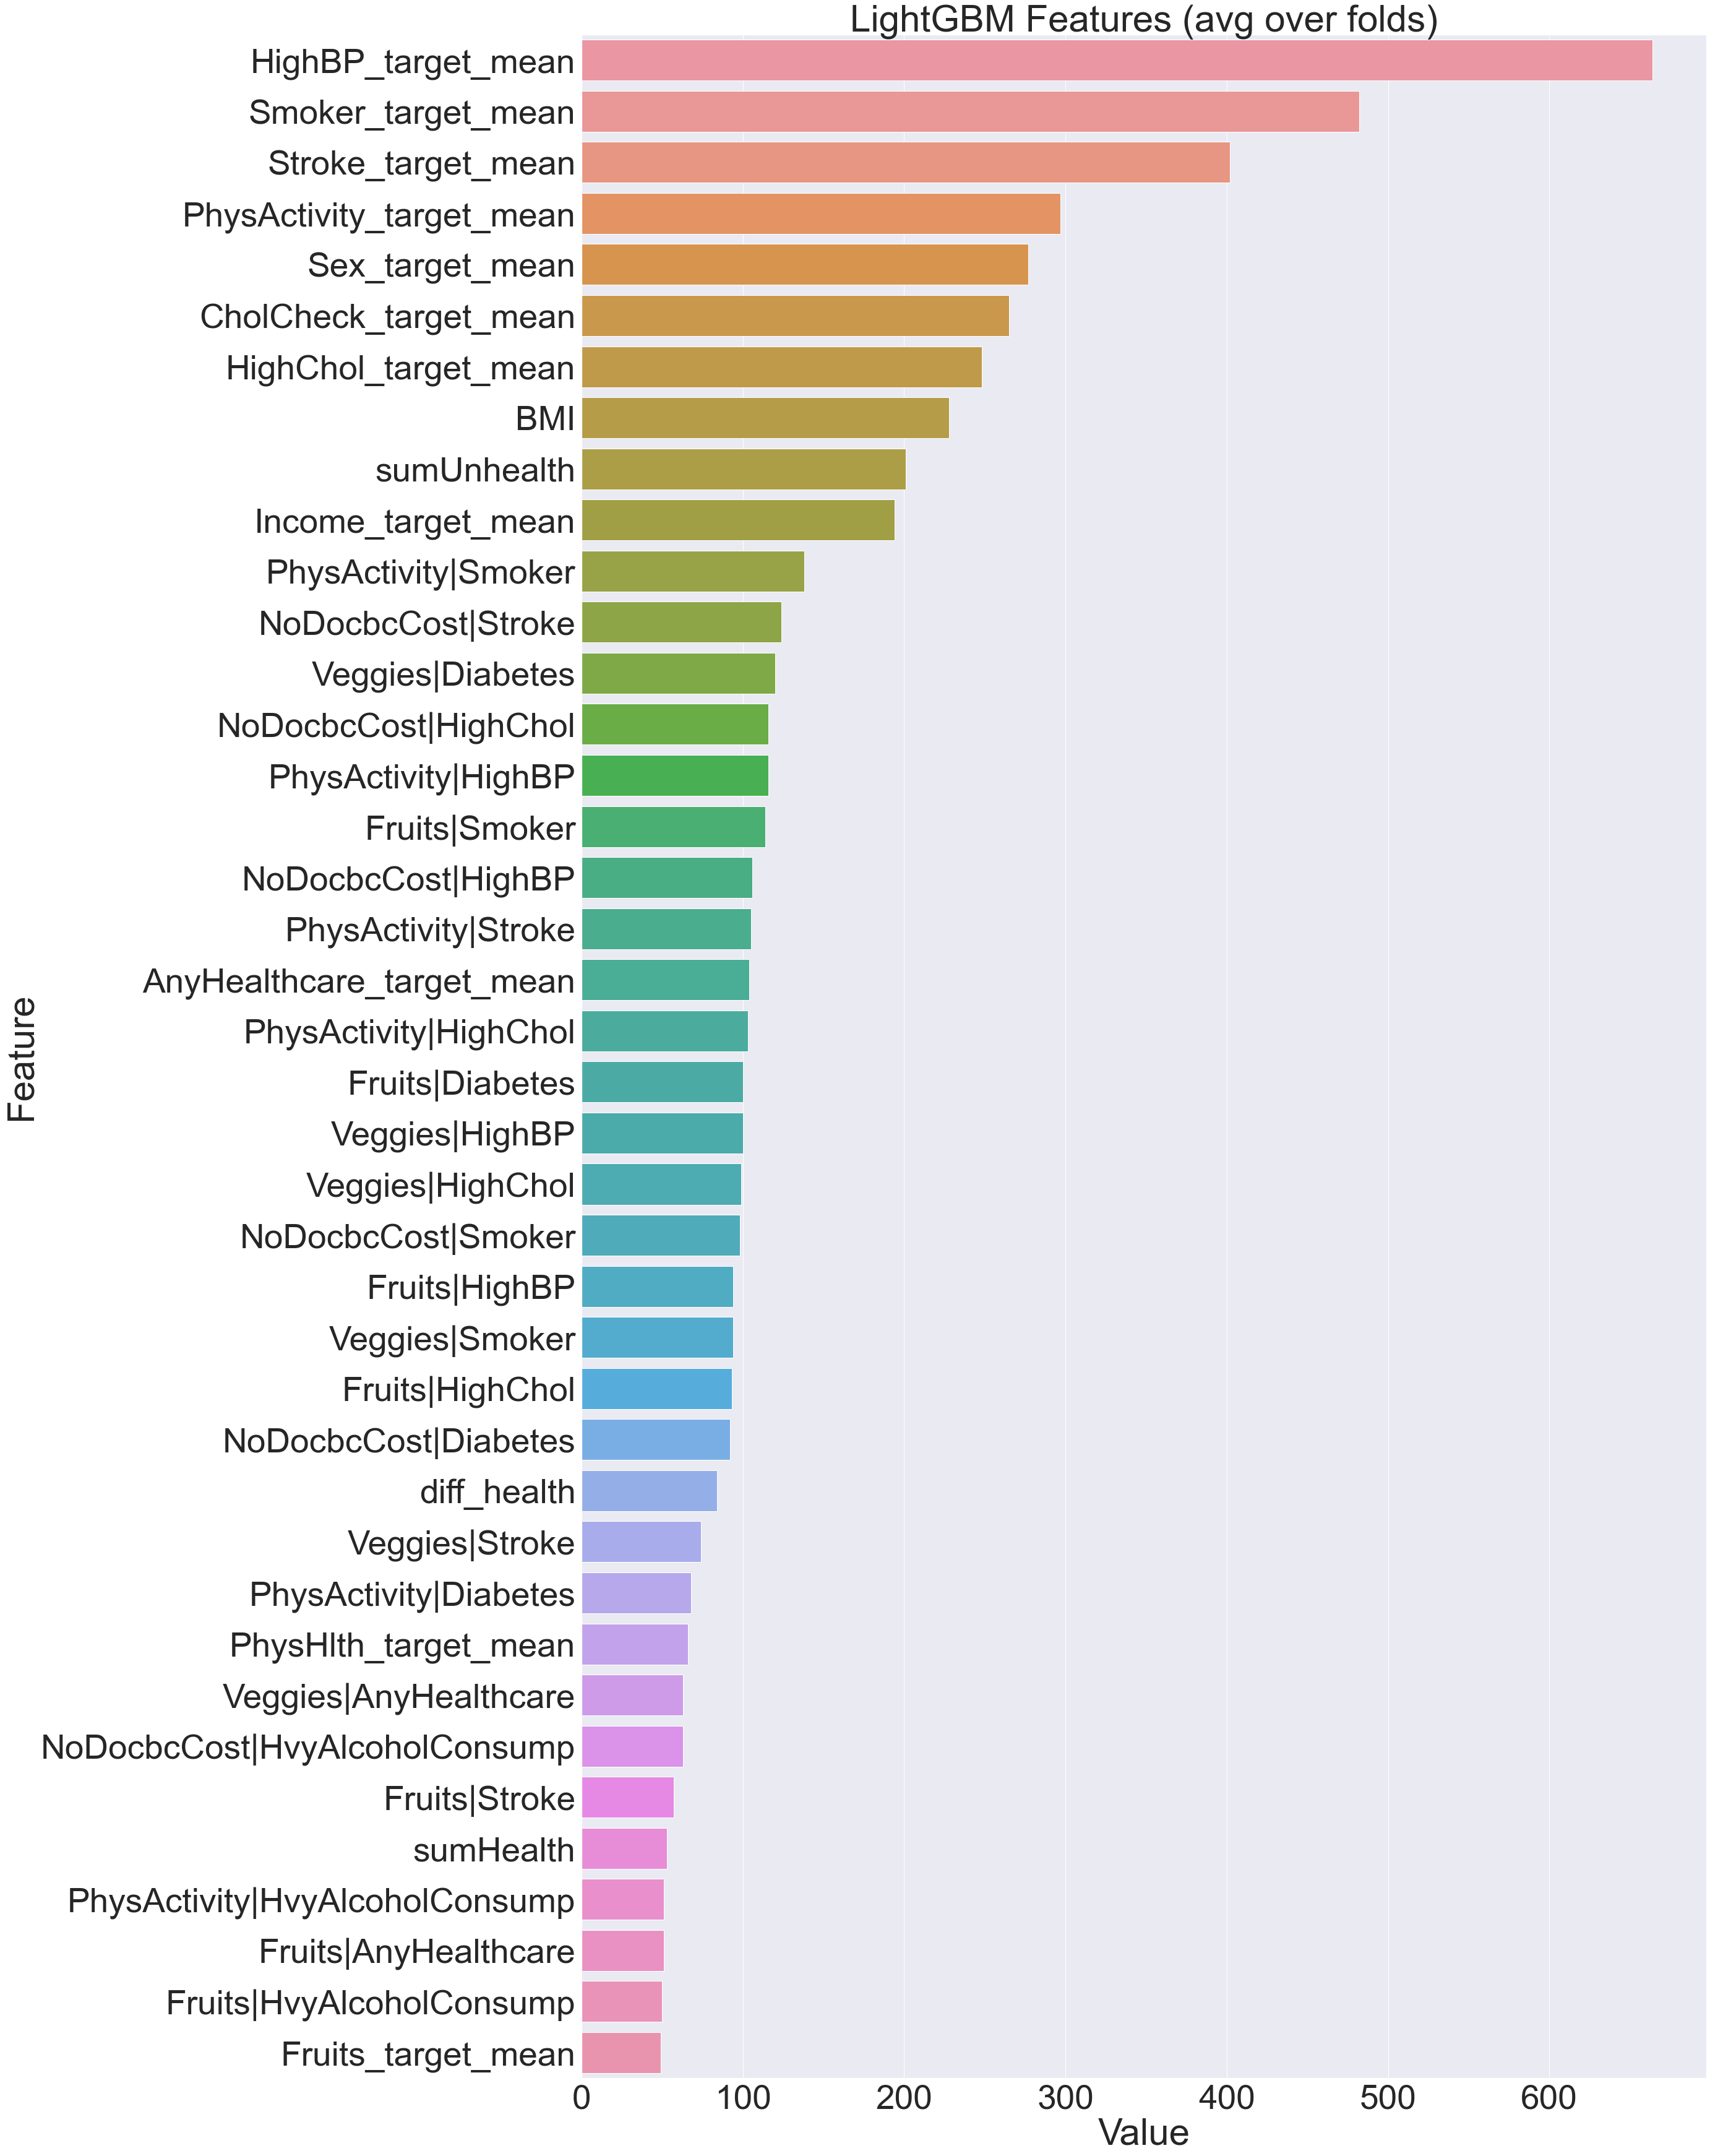

In [209]:
plotImp(lgbm, X_test, num=40)

+ feature importance

1. Lightgbm on unbalanced data without feature engineering
2. this model on whole data
3. add light gbm on the col models above

+ use the whole model to train

In [115]:
def prepare_train(train, target):
    train['sumHealth'] = train[health].sum(axis=1)
    train['sumUnhealth'] = train[unhealth].sum(axis=1)
    train['diff_health'] = train['sumHealth'] - train['sumUnhealth']

    ## Label encoding and interactive labels
    features_mean_enc = categorical_features + ordinal_features
    mean_enc_cat = target_enc(train[categorical_features+[target]], categorical_features, target)
    mean_enc_ord = target_enc(train[ordinal_features + [target]], ordinal_features, target)
    
    train = pd.concat([train.drop(columns=features_mean_enc), mean_enc_ord, mean_enc_cat], axis=1)
    
    for i in health:
        for j in unhealth:
            train[i+'|'+j] = train[i+'_target_mean'] * train[j+'_target_mean']
            
    return train

In [150]:
train.columns

Index(['HeartDiseaseorAttack', 'BMI', 'sumHealth', 'sumUnhealth',
       'diff_health', 'Education_target_mean', 'Age_target_mean',
       'PhysHlth_target_mean', 'MentHlth_target_mean', 'GenHlth_target_mean',
       'Income_target_mean', 'Sex_target_mean', 'HighBP_target_mean',
       'HighChol_target_mean', 'CholCheck_target_mean', 'Smoker_target_mean',
       'Stroke_target_mean', 'PhysActivity_target_mean', 'Fruits_target_mean',
       'Veggies_target_mean', 'Diabetes_target_mean',
       'HvyAlcoholConsump_target_mean', 'AnyHealthcare_target_mean',
       'NoDocbcCost_target_mean', 'DiffWalk_target_mean',
       'PhysActivity|HighBP', 'PhysActivity|HighChol',
       'PhysActivity|CholCheck', 'PhysActivity|Smoker', 'PhysActivity|Stroke',
       'PhysActivity|Diabetes', 'PhysActivity|HvyAlcoholConsump',
       'PhysActivity|AnyHealthcare', 'Fruits|HighBP', 'Fruits|HighChol',
       'Fruits|CholCheck', 'Fruits|Smoker', 'Fruits|Stroke', 'Fruits|Diabetes',
       'Fruits|HvyAlcoholCons

In [151]:
test.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'HeartDiseaseorAttack',
       'sumHealth', 'sumUnhealth', 'diff_health'],
      dtype='object')

In [159]:
train = prepare_train(train_val, target)

In [160]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=[target]), train[target], test_size=0.1)

In [161]:
test = pd.concat([X_test, y_test], axis=1)
test_set = prepare_test(test, train_val, target)

In [162]:
X_test_ = test_set.drop(columns=[target])
y_test_ = test_set[target]

In [163]:
lgbm2 = lgb.LGBMClassifier(**params)
lgbm2.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20)

[1]	valid_0's auc: 0.824869
[2]	valid_0's auc: 0.833936
[3]	valid_0's auc: 0.837727
[4]	valid_0's auc: 0.838381
[5]	valid_0's auc: 0.840929
[6]	valid_0's auc: 0.841857
[7]	valid_0's auc: 0.844038
[8]	valid_0's auc: 0.844431
[9]	valid_0's auc: 0.844954
[10]	valid_0's auc: 0.845477
[11]	valid_0's auc: 0.84543
[12]	valid_0's auc: 0.8454
[13]	valid_0's auc: 0.84526
[14]	valid_0's auc: 0.845295
[15]	valid_0's auc: 0.845514
[16]	valid_0's auc: 0.846021
[17]	valid_0's auc: 0.846077
[18]	valid_0's auc: 0.846171
[19]	valid_0's auc: 0.846406
[20]	valid_0's auc: 0.846419
[21]	valid_0's auc: 0.846502
[22]	valid_0's auc: 0.846972
[23]	valid_0's auc: 0.846894
[24]	valid_0's auc: 0.84689
[25]	valid_0's auc: 0.846877
[26]	valid_0's auc: 0.84694
[27]	valid_0's auc: 0.847178
[28]	valid_0's auc: 0.847188
[29]	valid_0's auc: 0.847196
[30]	valid_0's auc: 0.847368
[31]	valid_0's auc: 0.847548
[32]	valid_0's auc: 0.84769
[33]	valid_0's auc: 0.847944
[34]	valid_0's auc: 0.848135
[35]	valid_0's auc: 0.848255
[

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_bin=512,
               metric='auc', num_leaves=64, objective='binary', reg_alpha=5,
               reg_lambda=10, subsample=1, subsample_for_bin=200,
               subsample_freq=1)

In [164]:
lgbm2.score(X_test_, y_test_)

0.9058065279091769

In [138]:
X_train.shape

(182649, 56)

In [139]:
df_copy3.shape

(38228, 57)

In [165]:
def prepare_train(train, target):
    train['sumHealth'] = train[health].sum(axis=1)
    train['sumUnhealth'] = train[unhealth].sum(axis=1)
    train['diff_health'] = train['sumHealth'] - train['sumUnhealth']

    ## Label encoding and interactive labels
    features_mean_enc = categorical_features
    mean_enc_cat = target_enc(train[categorical_features+[target]], categorical_features, target)
    #mean_enc_ord = target_enc(train[ordinal_features + [target]], ordinal_features, target)
    
    train = pd.concat([train.drop(columns=features_mean_enc), mean_enc_cat], axis=1)
    
    for i in health:
        for j in unhealth:
            train[i+'|'+j] = train[i+'_target_mean'] * train[j+'_target_mean']
            
    return train


def prepare_test(test, train, target):
    test['sumHealth'] = test[health].sum(axis=1)
    test['sumUnhealth'] = test[unhealth].sum(axis=1)
    test['diff_health'] = test['sumHealth'] - test['sumUnhealth']
    
    features_to_enc = categorical_features
    for feature in features_to_enc:
        test[feature + '_target_mean'] = test[feature].map(train.groupby(by=feature)[target].mean())
        
    prior = train[target].mean()
    test[features_to_enc].fillna(prior, inplace=True)
    
    #Smooth
    for feature in features_to_enc:
        test[feature] = test[feature] * len(test) + test[feature].nunique() * prior
        test[feature] = test[feature] / (len(test) + test[feature].nunique())
    
    for i in health:
        for j in unhealth:
            test[i+'|'+j] = test[i+'_target_mean'] * test[j+'_target_mean']
    
    test = test.drop(columns=features_to_enc)
    return test

In [168]:
def prepare(train_val, X_test, y_test, target):
    train = prepare_train(train_val, target)
    X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=[target]), train[target], test_size=0.1)
    test = pd.concat([X_test, y_test], axis=1)
    test_set = prepare_test(test, train_val, target)
    X_test_ = test_set.drop(columns=[target])
    y_test_ = test_set[target]
    
    
    return X_train, X_val, y_train, y_val, X_test_, y_test_

In [169]:
X_train, X_val, y_train, y_val, X_test_, y_test_ = prepare(train_val, X_test, y_test, target)

In [170]:
lgbm3 = lgb.LGBMClassifier(**params)
lgbm3.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

[1]	valid_0's auc: 0.817541
[2]	valid_0's auc: 0.826154
[3]	valid_0's auc: 0.824158
[4]	valid_0's auc: 0.821616
[5]	valid_0's auc: 0.829211
[6]	valid_0's auc: 0.82875
[7]	valid_0's auc: 0.827434
[8]	valid_0's auc: 0.831876
[9]	valid_0's auc: 0.834665
[10]	valid_0's auc: 0.836084
[11]	valid_0's auc: 0.837567
[12]	valid_0's auc: 0.838269
[13]	valid_0's auc: 0.839005
[14]	valid_0's auc: 0.839558
[15]	valid_0's auc: 0.840142
[16]	valid_0's auc: 0.840528
[17]	valid_0's auc: 0.840878
[18]	valid_0's auc: 0.841122
[19]	valid_0's auc: 0.841386
[20]	valid_0's auc: 0.841349
[21]	valid_0's auc: 0.841342
[22]	valid_0's auc: 0.841528
[23]	valid_0's auc: 0.841643
[24]	valid_0's auc: 0.841725
[25]	valid_0's auc: 0.841804
[26]	valid_0's auc: 0.841747
[27]	valid_0's auc: 0.841803
[28]	valid_0's auc: 0.842034
[29]	valid_0's auc: 0.842223
[30]	valid_0's auc: 0.842336
[31]	valid_0's auc: 0.842261
[32]	valid_0's auc: 0.842415
[33]	valid_0's auc: 0.842605
[34]	valid_0's auc: 0.84273
[35]	valid_0's auc: 0.842

0.907639545884579

In [171]:
lgbm3.score(X_test_, y_test_)

0.907639545884579

+ Parameter tuning

In [175]:
grid_params = {'learning_rate': np.linspace(0.01, 0.3, 10), 'n_estimators': [100, 200, 400, 500],
                   'max_depth': np.arange(3, 13), 
                    'num_leaves': np.arange(0, 1000, 50), 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'feature_fraction': [0.6,0.65, 0.75, 0.8, 0.9], 
                   'bagging_fraction': [0.6, 0.7, 0.75, 0.8, 0.9], 'reg_alpha': [1, 2, 6, 10, 20, 30],
                   'reg_lambda': [1, 2, 6, 10, 20, 30]}

In [176]:
lgbm4 = lgb.LGBMClassifier()
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

In [179]:
from sklearn.model_selection import RandomizedSearchCV
grid = RandomizedSearchCV(lgbm4,grid_params, n_jobs=-1, cv=5, scoring='accuracy')
grid.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.6, 0.7, 0.75,
                                                             0.8, 0.9],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.6, 0.65, 0.75,
                                                             0.8, 0.9],
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                                        'n_estimators': [100, 200, 400, 500],
                                        'num_leaves': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900, 950]),
                           

In [180]:
best_model = grid.best_estimator_
best_model.score(X_test_, y_test_)

0.9076592557552823

In [181]:
grid.best_params_

{'seed': 500,
 'reg_lambda': 1,
 'reg_alpha': 30,
 'objective': 'binary',
 'num_leaves': 950,
 'n_estimators': 200,
 'max_depth': 8,
 'learning_rate': 0.07444444444444444,
 'feature_fraction': 0.65,
 'boosting_type': 'gbdt',
 'bagging_fraction': 0.9}